<a href="https://colab.research.google.com/github/farrelrassya/teachingMLDL/blob/main/01.%20Machine%20Learning/06.%20Week%206/Notebook/02_Dendograms%26HierarchicalClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import sys
#!{sys.executable} -m pip install kneed

In [2]:
pip install kneed

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Load dataset
data = pd.read_excel('/content/sample_data/Online Retail.xlsx')

# Data preprocessing: removing rows with missing CustomerID and filtering for positive quantities and prices
data = data.dropna(subset=['CustomerID'])
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

# Feature engineering: Aggregate data by CustomerID
customer_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'InvoiceNo': 'nunique'
}).rename(columns={'InvoiceNo': 'PurchaseFrequency'})

# Standardizing features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

# Reduce dimensions for visualization purposes (optional)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Plotting function for clusters
def plot_clusters(data, labels, title):
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.show()


In [6]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


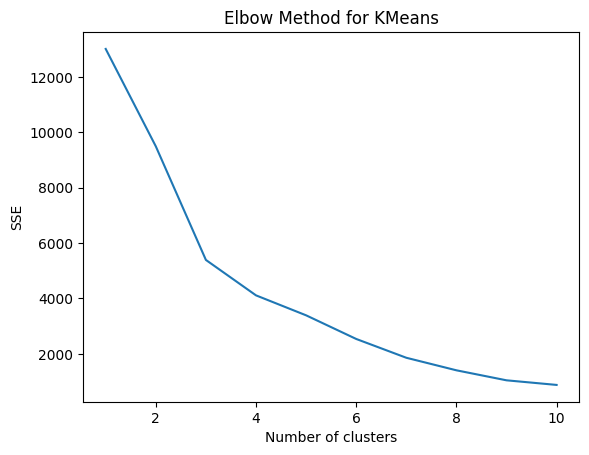

Optimal K (Elbow): 3
KMeans Silhouette Score: 0.949913025911316


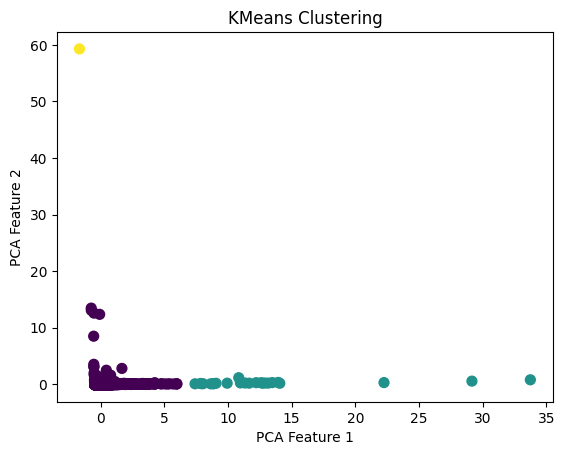

DBSCAN Silhouette Score: 0.6664008024945139


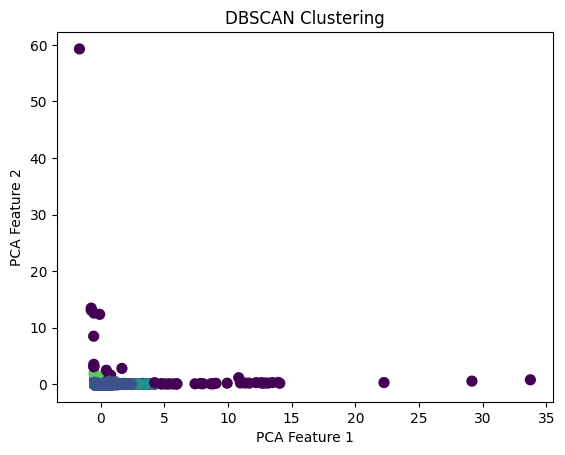

Agglomerative Clustering Silhouette Score: 0.7523353502311838


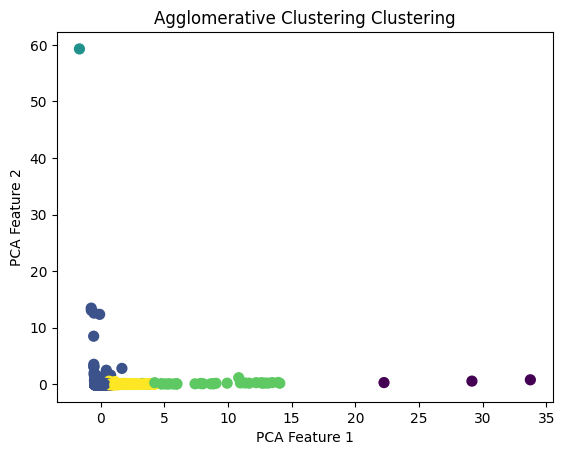

In [7]:
# Initialize models
kmeans = KMeans(n_clusters=5, random_state=42)
dbscan = DBSCAN(eps=0.5, min_samples=5)
agg_clustering = AgglomerativeClustering(n_clusters=5)

# Function to evaluate model
def evaluate_model(model, data, model_name):
    labels = model.fit_predict(data)
    silhouette_avg = silhouette_score(data, labels) if len(set(labels)) > 1 else -1
    print(f"{model_name} Silhouette Score: {silhouette_avg}")
    plot_clusters(pca_data, labels, f"{model_name} Clustering")
    return labels, silhouette_avg

# Elbow method for KMeans
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

# Plotting Elbow
plt.plot(range(1, 11), sse)
plt.title('Elbow Method for KMeans')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# Finding optimal K using KneeLocator
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
optimal_k = kl.elbow
print(f"Optimal K (Elbow): {optimal_k}")

# Apply each model
labels_kmeans, silhouette_kmeans = evaluate_model(KMeans(n_clusters=optimal_k), scaled_data, "KMeans")
labels_dbscan, silhouette_dbscan = evaluate_model(dbscan, scaled_data, "DBSCAN")
labels_agg, silhouette_agg = evaluate_model(agg_clustering, scaled_data, "Agglomerative Clustering")


In [8]:
# Model evaluation summary
evaluation_summary = {
    'Model': ['KMeans', 'DBSCAN', 'Agglomerative Clustering'],
    'Silhouette Score': [silhouette_kmeans, silhouette_dbscan, silhouette_agg]
}
evaluation_df = pd.DataFrame(evaluation_summary)
print(evaluation_df)

# Best model based on silhouette score
best_model = evaluation_df.loc[evaluation_df['Silhouette Score'].idxmax()]
print("\nBest model based on Silhouette Score:")
print(best_model)


                      Model  Silhouette Score
0                    KMeans          0.949913
1                    DBSCAN          0.666401
2  Agglomerative Clustering          0.752335

Best model based on Silhouette Score:
Model                 KMeans
Silhouette Score    0.949913
Name: 0, dtype: object
